In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# lattice and data directory
p0c = 43.36e6 # reference momentum in eV/c
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
data_dir = os.path.join('data', 'yaml_files')

In [3]:
# create gaussian and nongaussian beams using Bmad-X distgen functionality
gaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

nongaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

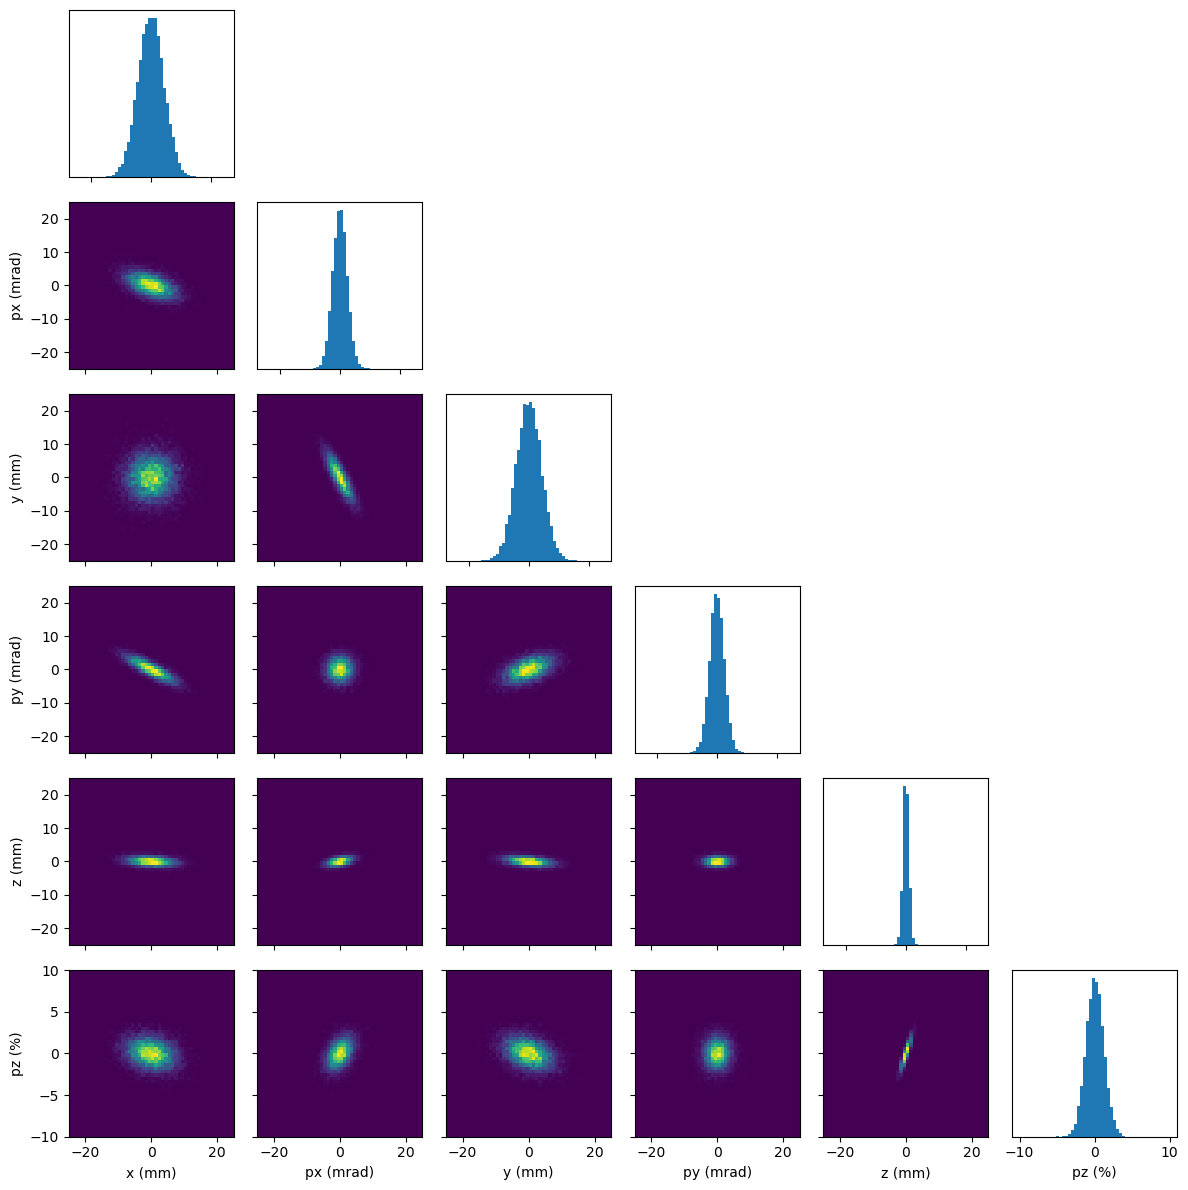

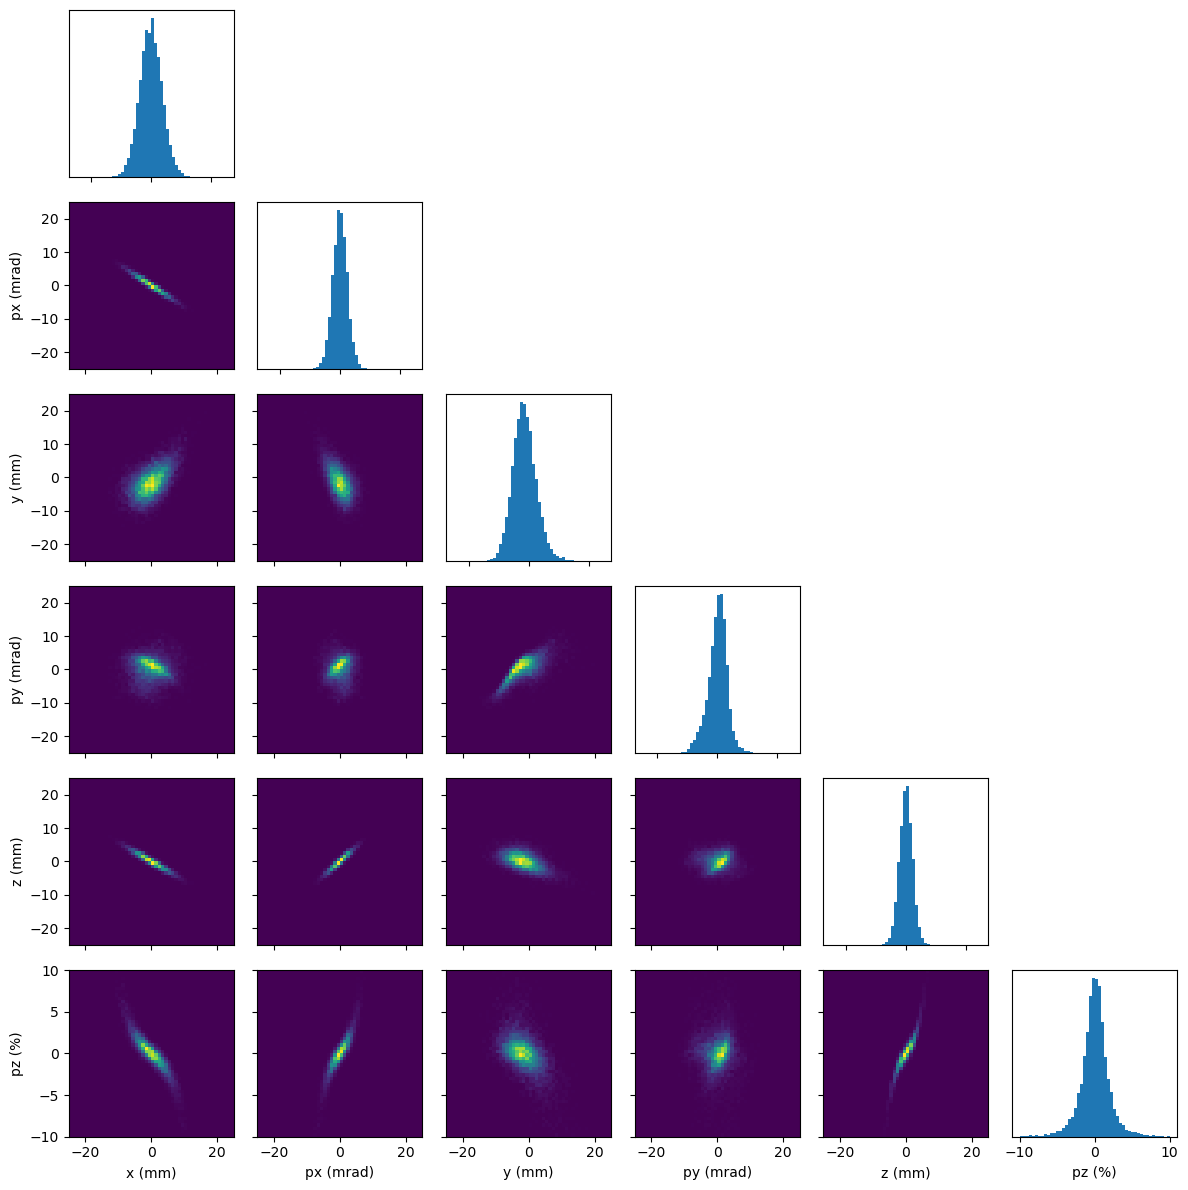

In [4]:
# plot linear and nonlinear beams
lims = np.array(
    [[-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-10e-2, 10e-2]]
    )
fig, ax = plot_projections(gaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(nongaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [5]:
# use xopt for optimization
from triplet_opt import optimize_function, output
from xopt import VOCS

opt_vocs = VOCS(
        variables = {"k1":[0,20], "k2":[-30,0], "k3":[0,30]},
        objectives = {"total_size": "MINIMIZE"}
    )

opt_gaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': gaussian_beam,
        'lattice': lattice
    },
    #generator_kwargs={"turbo_controller":"optimize"}
)

opt_nongaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': nongaussian_beam,
        'lattice': lattice
    },
    #generator_kwargs={"turbo_controller":"optimize"}
)

/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# optimization results for linear beam
opt_gaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
0,9.279185,-14.333935,22.162979,0.004032,0.038837,0.039046,0.037865,False
1,6.981626,-21.007009,8.082452,0.021160,0.022117,0.030609,0.036113,False
2,14.208256,-16.778255,28.199810,0.012365,0.057684,0.058994,0.035483,False
3,15.427032,-19.530678,0.549525,0.063438,0.043061,0.076672,0.035681,False
4,15.020270,-2.277895,8.729238,0.013579,0.066957,0.068320,0.035885,False
...,...,...,...,...,...,...,...,...
101,0.529541,-25.130357,15.338702,0.010749,0.019139,0.021951,0.022834,False
102,1.266705,-0.054975,15.701617,0.010757,0.046646,0.047871,0.022645,False
103,1.895460,-17.871339,17.558246,0.005171,0.005287,0.007395,0.022601,False
104,0.842935,-11.276499,29.780122,0.017773,0.039657,0.043457,0.022901,False


In [7]:
opt_gaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1    10.986991
k2   -24.674763
k3    26.907939
Name: 105, dtype: object

In [8]:
# optimization results for nonlinear beam
opt_nongaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
0,17.751482,-15.422225,1.033635,0.064104,0.026057,0.069197,0.022726,False
1,7.801988,-22.178740,16.795616,0.013238,0.009325,0.016193,0.022642,False
2,3.431718,-25.022365,4.798260,0.016264,0.036901,0.040326,0.022631,False
3,15.442692,-25.513402,8.074584,0.054348,0.050711,0.074332,0.022589,False
4,11.391052,-9.833136,4.344957,0.028370,0.010859,0.030377,0.022580,False
...,...,...,...,...,...,...,...,...
101,4.632538,-24.741826,27.789267,0.002017,0.004360,0.004804,0.022772,False
102,0.358311,-19.124522,2.651172,0.006022,0.021852,0.022666,0.022810,False
103,11.115551,-0.630441,9.031715,0.008866,0.068635,0.069205,0.022690,False
104,19.998350,-16.032480,11.955673,0.033458,0.014541,0.036481,0.022585,False


In [9]:
opt_nongaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1      6.10308
k2   -24.441689
k3    25.971829
Name: 105, dtype: object

<Axes: >

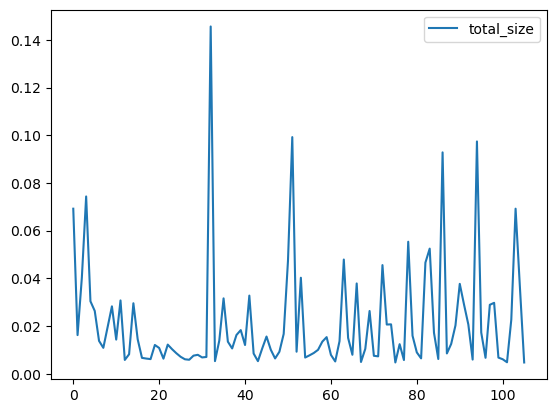

In [10]:
opt_nongaussian_beam.data.plot(y="total_size")